# Processing Echosounder Data using `echopype`.

In this notebook we demonstrate how to process echosounder data using `echopype`.

We pick data from the Ocean Observatories Initiative (OOI) [Oregon Offshore Cabled Shallow Profiler Mooring](https://oceanobservatories.org/site/ce04osps/) collected on August 21, 2017. This was the day of the solar eclipse, during which the reduced sunlight affected the regular diel vertical migration (DVM) patterns of marine life. This change was directly observed using a moored echosounder that happened to be within the totality zone.

## Processing 1 file
Let's first test downloading and processing 1 file.

**Install echopype**

In [1]:
!pip install echopype

  Using cached https://files.pythonhosted.org/packages/7b/02/751b614e12e8674011b03e9d47dca00e33ff94e6a20e65a4ac5c857fc62c/echopype-0.1.21-py3-none-any.whl


In [2]:
# downloading the file
!wget https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143/OOI-D20170821-T163049.raw 

--2019-07-11 01:51:33--  https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143/OOI-D20170821-T163049.raw
Resolving rawdata.oceanobservatories.org (rawdata.oceanobservatories.org)... 128.6.240.153
Connecting to rawdata.oceanobservatories.org (rawdata.oceanobservatories.org)|128.6.240.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52431936 (50M) [text/plain]
Saving to: ‘OOI-D20170821-T163049.raw’

OOI-D20170821-T1630 100%[===================>]  50.00M   357KB/s    in 2m 42s  

2019-07-11 01:54:16 (315 KB/s) - ‘OOI-D20170821-T163049.raw’ saved [52431936/52431936]



In [3]:
filename = 'OOI-D20170821-T163049.raw'

**Converting from Raw to Standartized netCDF Format**

In [4]:
import os

In [6]:
# import as part of a submodule
from echopype.convert import ConvertEK60
data_tmp = ConvertEK60(filename)
data_tmp.raw2nc()
os.remove(filename)

01:56:33  converting file: OOI-D20170821-T163049.raw


**Calibrating, Denoising, Mean Volume Backscatter Strength**

In [7]:
from echopype.model import EchoData
data = EchoData(filename[:-4]+'.nc')
data.calibrate()  # Calibration and echo-integration
data.remove_noise(save=True)  # Save denoised Sv to FILENAME_Sv_clean.nc
data.get_MVBS(save=True)

01:56:42  saving calibrated Sv to OOI-D20170821-T163049_Sv.nc
01:56:53  saving denoised Sv to OOI-D20170821-T163049_Sv_clean.nc
01:56:55  saving MVBS to OOI-D20170821-T163049_MVBS.nc


**Visualizing the Result**

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

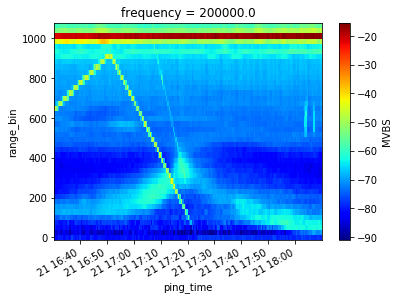

In [9]:
data.MVBS.MVBS.sel(frequency=200000).plot(x='ping_time',cmap = 'jet')
plt.show()

## Processing Multiple Files

Now that we verified that `echopype` does work, let's proceed to process all sonar data from August 21, 2017.

To process multiple file from the OOI website we need to scrape the names of the existing files there. We will use the `Beautiful Soup` package for that. 

In [10]:
!conda install --yes beautifulsoup4

Solving environment: - 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/noarch::dask==1.2.2=py_0
  - conda-forge/osx-64::pandas==0.24.1=py37h0a44026_0
  - defaults/noarch::xarray==0.12.1=py_0
done

## Package Plan ##

  environment location: /Users/wu-jung/miniconda3/envs/echopype

  added / updated specs:
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libedit-3.1.20181209       |       hb402a30_0         136 KB
    ------------------------------------------------------------
                                           Total:         136 KB

The following NEW packages will be INSTALLED:

  pytz               pkgs/main/noarch::pytz-2019.1-py_0

The following packages will be UPDATED:

  libedit            conda-forge::libedit-3.1.20170329-hcf~ --> pkgs/main::libedit-3.1.2018

In [11]:
from bs4 import BeautifulSoup
from urllib.request import urlopen

In [12]:
path = 'https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143/'

In [13]:
response = urlopen(path)
soup = BeautifulSoup(response.read(), "html.parser")

In [14]:
urls = []
for item in soup.find_all(text=True):
    if '.raw' in item:
        urls.append(path+'/'+item)        

In [15]:
urls = [path+'/'+item for item in soup.find_all(text=True) if '.raw' in item]

In [16]:
urls

['https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143//OOI-D20090101-T230000.raw',
 'https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143//OOI-D20090102-T000839.raw',
 'https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143//OOI-D20090102-T001829.raw',
 'https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143//OOI-D20090102-T171933.raw',
 'https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143//OOI-D20090102-T185935.raw',
 'https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143//OOI-D20090102-T224637.raw',
 'https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143//OOI-D20090102-T225749.raw',
 'https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143//OOI-D20090107-T191402.raw',
 'https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143//OO

In [17]:
from datetime import datetime

Specify range:

In [36]:
start_time = '20170821-T06000'
end_time = '20170822-T070000'
# end_time = '20170822-T235959'

In [37]:
# convert the times to datetime format
start_datetime = datetime.strptime(start_time,'%Y%m%d-T%H%M%S')
end_datetime = datetime.strptime(end_time,'%Y%m%d-T%H%M%S')

In [38]:
# function to check if a date is in the date range
def in_range(date_str, start_time, end_time):
    date_str = datetime.strptime(date_str,'%Y%m%d-T%H%M%S')
    true = date_str >= start_datetime and date_str <= end_datetime
    return(true)
    

In [39]:
# identify the list of urls in range
range_urls = []
for url in urls: 
    date_str = url[-20:-4]
    if in_range(date_str, start_time, end_time):
        range_urls.append(url)
        

In [40]:
range_urls

['https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143//OOI-D20170821-T063618.raw',
 'https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143//OOI-D20170821-T081522.raw',
 'https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143//OOI-D20170821-T095435.raw',
 'https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143//OOI-D20170821-T113343.raw',
 'https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143//OOI-D20170821-T131245.raw',
 'https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143//OOI-D20170821-T145147.raw',
 'https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143//OOI-D20170821-T163049.raw',
 'https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143//OOI-D20170821-T180952.raw',
 'https://rawdata.oceanobservatories.org/files/CE04OSPS/PC01B/ZPLSCB102_10.33.10.143//OO

In [34]:
rawnames = [url.split('//')[-1] for url in range_urls]

**Downloading the Files**

In [35]:
import requests
rawnames = []
for url in range_urls:
    r = requests.get(url, allow_redirects=True)
    rawnames.append(url.split('//')[-1])
    open(url.split('//')[-1], 'wb').write(r.content)

KeyboardInterrupt: 

In [ ]:
ls

**Converting from Raw to Standartized netCDF Format**

In [ ]:
# import as part of a submodule
from echopype.convert import ConvertEK60
for filename in rawnames:
    data_tmp = ConvertEK60(filename)
    data_tmp.raw2nc()
    os.remove(filename)

**Calibrating, Denoising, Mean Volume Backscatter Strength**

In [ ]:
# calibrate and denoise
from echopype.model import EchoData

for filename in rawnames:

    data = EchoData(filename[:-4]+'.nc')
    data.calibrate()  # Calibration and echo-integration
    data.remove_noise(save=False)  # Save denoised Sv to FILENAME_Sv_clean.nc
    data.get_MVBS(save=True)
    os.remove(filename[:-4]+'.nc')
    os.remove(filename[:-4]+'_Sv.nc')

**Opening and Visualizing the Results in Parallel**

Now that all files are in an appropriate format, we can open them and visualize them in parallel. For that we will need to install the `dask` parallelization library.

In [ ]:
!conda install --yes dask

In [ ]:
import xarray as xr

In [ ]:
res = xr.open_mfdataset('*MVBS.nc')

In [ ]:
# Add coordinate variable depth
res.coords['depth'] = res.range_bin * res.sample_thickness.sel(frequency=200000).isel(ping_time=0).values
res.coords['depth'] = res.coords['depth'].max() - res.coords['depth']

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
echogram = res.MVBS.sel(frequency=200000).\
            sel(ping_time=slice('2017-08-21 07:00:00',
                                '2017-08-22 07:00:00')).\
            plot(x='ping_time',y='depth',cmap='jet',
                 vmin=-80,vmax=-30,aspect=3, size=5)
plt.ylim(res.coords['depth'].max(), 0)
plt.xlabel('Ping time', fontsize=14)
plt.ylabel('Depth (m)', fontsize=14)
plt.show()

## Combine sonar observation with solar radiation measurements

Now we've seen how the echogram looks like during the day of eclipse, let's match the sonar observation with the solar radiation measurements.

From the National Data Buoy Center (http://www.ndbc.noaa.gov/) we see that there is a surface buoy with a pyranometer that measures shortwave radiation (SRAD1 on the NDBC website) at the EAO site (Station 46098: http://www.ndbc.noaa.gov/station_page.php?station=46098). Let's access the data and check it out!

In [ ]:
import gzip
import requests
import urllib
from datetime import datetime
import numpy as np
import pandas as pd

First we need to construct the url to the historical data.

In [ ]:
srad_url = 'https://www.ndbc.noaa.gov/data/historical/srad/'
filename = '46098'+'r'+'2017'+'.txt.gz'
fileurl = srad_url+filename

And then we open up the file and read all measurements from 2017.

In [ ]:
f = gzip.open(urllib.request.urlopen(fileurl))
lines = [line.decode().strip() for line in f.readlines()]

In [ ]:
lines[:2]

This tells us that the first 5 columns are measurement timestamp, and the 6th column is the short wave radiation measurement. Let's now parse the entire 2017 data set.

In [ ]:
srad1_time = []
srad1 = []
for line in lines[2:]:
    line = line.split()
    srad1_time.append(datetime.strptime(''.join(line[:5]), '%Y%m%d%H%M'))
    nn = 5  # the 6th column is SRAD1
    srad1.append(np.nan if line[nn] == '9999.0' else float(line[nn]))

Make it into a pandas DataFrame for convenience.

In [ ]:
df_srad = pd.DataFrame(srad1, columns=['SRAD'], index=srad1_time)

Now we can finally put everything together and figure out the effect of eclipse on the marine animals!

In [ ]:
import matplotlib.dates as mdates

In [ ]:
fig = plt.figure(figsize=(12,7))
ax0 = plt.subplot2grid((3, 1), (0, 0))
ax1 = plt.subplot2grid((3, 1), (1, 0),rowspan=2)

df_srad[np.logical_and(df_srad.index>=pd.to_datetime('2017-08-21 07:00:00'), 
                       df_srad.index<=pd.to_datetime('2017-08-22 07:00:00'))].plot(ax=ax0, logy=True, color='r')
ax0.set_ylabel('Radiation (W/m^2)', fontsize=14)

echogram = res.MVBS.sel(frequency=200000).\
            sel(ping_time=slice('2017-08-21 07:00:00',
                                '2017-08-22 07:00:00')).\
            plot(x='ping_time',y='depth',cmap='jet',
                 vmin=-80, vmax=-30, ax=ax1, add_colorbar=False)
plt.ylim(res.coords['depth'].max(), 0)
plt.xlabel('Time (UTC)', fontsize=14)
plt.ylabel('Depth (m)', fontsize=14)
plt.title('')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d %H:%M'))
plt.show()